# part0: imports

In [1]:
import os, sys, pathlib
from pprint import pprint
import gc
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
from IPython.display import display, clear_output

import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import MaxNLocator
from matplotlib.collections import LineCollection
%matplotlib inline
%config InlineBackend.figure_formats = ['png2x']


import pyaldata as pyal

try:
    nbPath = pathlib.Path.cwd()
    RepoPath = nbPath.parent
    os.chdir(RepoPath)

    from tools import utilityTools as utility
    from tools import dataTools as dt
    from mouse import defs as mouse_defs
    from monkey import defs as monkey_defs
    import params
    
    os.chdir(RepoPath / 'monkey')
    %run "_dataset-selection.ipynb"
    
    set_rc =  params.set_rc_params
    set_rc()
    root = params.root
finally:
    os.chdir(nbPath)

n_components = 10    

if "__file__" not in dir():
    reload(dt)
    reload(mouse_defs)
    reload(monkey_defs)
    
    print('Done!')

the variable `GoodDataList` contains the session names
Done!


# reading data

In [2]:
animalList = ['mouse-data']

animalFiles = []
for animal in animalList:
    animalFiles.extend(utility.find_file(root/animal, 'mat'))


AllDFs=[]
for fname in animalFiles:
    print(fname)
    df = dt.load_pyal_data(fname)
    df['mouse'] = fname.split(os.sep)[-1][fname.split(os.sep)[-1].find('WR'):].split('_')[0]
    df['file'] = fname.split(os.sep)[-1]
    df = mouse_defs.prep_general_mouse(df)
    AllDFs.append(df)

clear_output()

In [3]:
warnings.filterwarnings("ignore")
allDFs_M1 = []
for animal, sessionList in GoodDataList[monkey_defs.areas[0]].items():
    if 'Mr' in animal:
        continue  # to remove MrT
    for session in sessionList:
        path = root/animal/session
        allDFs_M1.append(monkey_defs.prep_general(dt.load_pyal_data(path)))
        

allDFs_PMd = []
for animal, sessionList in GoodDataList[monkey_defs.areas[1]].items():
    if 'Mr' in animal:
        continue  # to remove MrT
    for session in sessionList:
        path = root/animal/session
        allDFs_PMd.append(monkey_defs.prep_general(dt.load_pyal_data(path)))
        
warnings.filterwarnings("default")

# Alignment across mice and monkeys

## M1

In [4]:
pairDfM1 = []
for I, monkey_df in enumerate(allDFs_M1):
    for J, mouse_df in enumerate(AllDFs):
        pairDfM1.append((monkey_df,mouse_df))

print(f'{len(pairDfM1)=}')

len(pairDfM1)=84


In [21]:
side1df = [monkey for monkey,_ in pairDfM1]
side2df = [mouse for _,mouse in pairDfM1]

warnings.filterwarnings("ignore")
AllData_monkey = dt.get_data_array(side1df, monkey_defs.exec_epoch, area=monkey_defs.areas[0], model=n_components)
AllData_mouse = dt.get_data_array(side2df, mouse_defs.exec_epoch, area=mouse_defs.areas[0], model=n_components)
warnings.filterwarnings("default")

allCCs=[]
for sessionData1,sessionData2 in zip(AllData_monkey,AllData_mouse):
    # concatenate the targets along the trials
    data1 = np.reshape(sessionData1, (-1,*sessionData1.shape[2:]))
    data2 = np.reshape(sessionData2, (-1,*sessionData2.shape[2:]))
    # shuffle the trial x target axis
    params.rng.shuffle(data1,axis=0)
    params.rng.shuffle(data2,axis=0)
    min_trials, min_time,_ = np.min((data2.shape,data1.shape),axis=0)
    data1 = np.reshape(data1[:min_trials,:min_time,:], (-1,n_components))
    data2 = np.reshape(data2[:min_trials,:min_time,:], (-1,n_components))
    allCCs.append(dt.canoncorr(data1, data2))
allCCs = np.array(allCCs).T


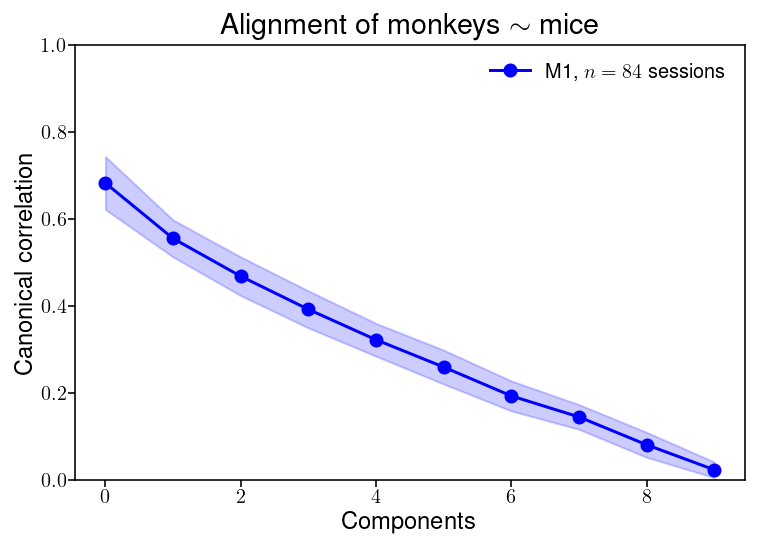

In [22]:
# plot
_,ax = plt.subplots()
utility.shaded_errorbar(ax, allCCs, color='b', marker = 'o', label=f'{monkey_defs.areas[0]}, $n={allCCs.shape[1]}$ sessions')
ax.set_ylim([0,1])
ax.set_xlabel('Components')
ax.legend()
ax.set_ylabel('Canonical correlation')
ax.set_title(r'Alignment of monkeys $\sim$ mice');